# <div> The effect of aging in the human body's temperature
 <div> by Caio de Próspero Iglesias and Felipe Freire Pinto
<div> April $9^{th}$, 2020</div></div></div>

## 1. Introduction

### 1.1 Context

After last year's french heat waves (*canicules*) , which led to nearly 1500 deaths, the subject was on the spotlight all over the world. Although people of all ages got killed, the eldery people were the most affected: from the 1435 deaths, 974 were older than 75 years, according to [[1]]. Thus, this study aims to understand the reasons to this and to model how older people react to higher temperatures, using the bio heat equation, with some suitable adaptations. Hopefully, this can help us understand how to protect eldery people from this natural phenomena.

### 1.2 Installation of the required modules

We will model our problem as a Partial Differential Equation and we will use the Finite Element Method to compute the solution to our problem. Thus, let's start by downloading and importing all we will need.

**Remark**: this installation might take some time and it is needed if you are using Microsoft Azure Notebooks

[1]: https://www.vie-publique.fr/en-bref/270623-bilan-de-la-canicule-2019-1-500-deces-enregistres-cet-ete

In [1]:
!conda config --add channels conda-forge
!conda install -y -v fenics
!conda install -c conda-forge mshr -y

In [3]:
from mshr import Polygon, generate_mesh
import numpy as np
from matplotlib import pyplot as plt
from dolfin import *
from fenics import *

## 2. Presentation of the Problem

### 2.1 Introduction of the steady-state Bio Heat Equation 

Since we want to describe the temperature distribution in an eldery person while exposed to high temperatures, we need to know the mechanism of the heat transfer in an human body. The heat balance mechanism is really complicated and needs to account several factors, such as heat diffusion, metabolic heat generation, sweating, and much more. 

Luckly enough, a lot of different models have been developed in the field of Mathematical Biology and an useful adaptation of the classic heat equation has been elaborated. This equation is called the Bio heat equation and is the basis of pretty much any heat model envolving the human body. It's basically the heat equation, but with appropriate parameters, an additional term, that accounts for the diffusion factor between the blood and the tissues, and a Robin's boundary condition, which will be essential in our model, since it accounts for the sweating system [[6]]. This equation is a typical example of a parabolic Partial Differential Equation. However, in this particular project, we will be interested in the steady state solution, i.e. when $t\to\infty$ and $\lim_{t\to\infty} \partial_t\theta = 0 $ where $\theta$ is our unkown function, that represents the temperature $[°C]$.

Therefore, we can get the following equation (from [[4]] , [[5]] and  [[6]]), which will be used in our model:

\begin{equation}\label{eq1:eval}
 \tag{P}\begin{cases}
  -div(\kappa\ grad(\theta) - \rho_{b} c_{b} \omega_{b} (\theta_{art} - \theta) = f \mbox{ in  }\Omega,\\
  -\kappa \partial_{n}\theta = h (\theta - \theta_{out}) + EV \mbox { in } \partial\Omega
 \end{cases}
\end{equation}

Where $\kappa$ $[W/cm\,°C]$ is the thermal conductivity, $\rho_{b}$ $[g/cm^3]$ is the density of blood, $c_{b}$ $[J/g °C]$ is the blood specific heat capacity, $\omega_{b}$ $[s^{-1}]$ is the volumetric flow rate of blood, $\theta_{art}$ $[°C]$ is the arterial temperature, $\theta_{out}$ $[°C]$ is the outside temperature, *h* $[J/(cm^2\, s \, °C)]$is the heat transfer coefficient, which includes the convective and radiative heat losses, $EV$ $[W/cm^2]$ is the evaporative heat loss and $f$ $[W/cm^3]$ is a the basal metabolic rate.

### 2.2 Definition of the Constants  and Random Variables

#### 2.2.1 Definition of the Constants

We can then determine ([[4]],[[5]]) the values of our constants.

\begin{equation}
 \begin{cases}
  \rho_{b} = 1.0 \, g/cm^3 \\
   c_{b} = 4.2 \, J/g °C \\
  \omega_{b} = 0.0036 \, s^{-1} \\
  h = 0.000627 \, J/(cm^2\, s \, °C)
 \end{cases}
\end{equation}

We can then define them already in our Python script. 

[4]:https://www.researchgate.net/publication/313958781

[5]:http://www.diva-portal.org/smash/get/diva2:37698/FULLTEXT01.pdf

[6]:https://www.sciencedirect.com/science/article/pii/S1290072914003032

In [18]:
ro_b = 1.0 #g/cm3
c = 4.2 #J/g*C
w = 0.0036 #cm3/s
h = 0.000627 #J/cm2*s*C

#### 2.2.2 Definition of the Random variables 

In our problem, we are going to take 3 different values as Random Variables, since these values normally vary a lot, but in a known manner. After some research ([[4]] , [[5]] and  [[6]]) and some calculations, we can define the 3 random variables as follows:

- the outside temperature ($\theta_{out}$), which will be between $34°C$ and $38°C$, since we are interested in studying cases of high temperature and since those are the values where the sweating rate is defined (3.4);
- the arterial temperature ($\theta_{art}$), which is centered at $36°C$;
- the $\kappa_{0}$, which is centered in  $0.08 \; W/cm\,°C$, which was calculated using some different values of $\kappa$ for some parts of the human body with some weight values, that accounted for the volume density of each different part. The  $\kappa_{0}$ will later be used to define a function $\kappa$.

Thses random variables can be defined, mathematically, as follows:

\begin{equation}
\begin{cases}
  \theta_{out} = \mathcal{U}(34,38) \, °C \\
  \theta_{art} = \mathcal{N}(36, 0.5) \, °C \\
  \kappa_{0} = \mathcal{N}(0.08, 0.006) \, W/cm °C\\
 \end{cases}
\end{equation}

Then, we can already register this variables in our Python script.

[4]:https://www.researchgate.net/publication/313958781

[5]:http://www.diva-portal.org/smash/get/diva2:37698/FULLTEXT01.pdf

[6]:https://www.sciencedirect.com/science/article/pii/S1290072914003032

In [19]:
u_amb = np.random.uniform(low = 34, high = 38) #C
u_ar = np.random.normal(loc = 36, scale = 0.5) #C
k_const = np.random.normal(loc = 0.08, scale = 0.006) #W/cm*C

### 2.3 Definition of $\kappa$ and $f$ 

We are going to define the thermal conductivity $\kappa$ and the basal metabolism $f$ as two paraboloids that depend on the position (x,y).

$\kappa: (x,y) \mapsto \kappa_{0} (1-x^2/10000-y^2/10000)$ , 

which is obtained considering the $\kappa_{0}$ as the base value (see **3.2.2**) and considering that it should decrease continuously until it gets to the boundary, where its value is known (the conductivity of the skin), which is lower than $\kappa_{0}$.

$f: (x,y) \mapsto 0.0004 \; (1 - x^2/4900-y^2/4900 )$ ,

which represents the dispersion of the metabolic generation on the body, which is maximum at the core and then decreases continuously.

Let us then define $\kappa$ and $f$ in our Python script, using the Expression tool from FeniCS.
 

In [20]:
k = Expression(str(k_const) + '* (1 - x[0]*x[0]/100000 - x[0]*x[0]/100000)', degree = 2)
f =Expression('0.0004*(1 -(x[0]*x[0]/4900+x[1]*x[1]/4900))', degree = 2) 

### 2.4 Definition of $EV$ : adaptation of the model to eldery people

In our particular problem we will focus on the parameter $EV$, which is a function of the position $(x,y)$, and that represents, as said above, the evaporative heat loss. This parameter is specially important to our problem, because eldery people have reduced sweating rates, which might be one of the reasons to the bigger number of deaths of older people once a heat wave happens. This smaller sweating rate should, then, imply a greater temperature elevation in older individuals. 

#### 2.4.1 Model of the sweating rate

Using values obtained by the article [[6]] and doing a polynomial interpolation [[9]],one may get the polynomials that approximate the values for the sweating rates on the skin for an older (~ 75 years) and a younger (~ 25 years) person, for a umidity of approximately 60% and for $t\to\infty$. 

\begin{equation}
\tag{I}
\begin{cases}
SW_{young}(\theta_{out}) \approx 1214.5 - 72.6 \, \theta_{out} + 1.09 \, \theta_{out}^2  \; , \: for \; \theta_{out} \in \left[ 34, 38\right] \\
SW_{old}(\theta_{out}) \approx 117 - 7.7 \, \theta_{out} + 0.13 \, \theta_{out}^2 \; , \: for \; \theta_{out} \in \left[ 34, 38\right]
\end{cases}
\end{equation}

where $\theta_{out}$ is given in $[°C]$ and $SW$ is the sweating rate in $[g/min]$. If we plot those values we can have a better idea of how this polynomials behave. 

[6]: https://www.sciencedirect.com/science/article/pii/S1290072914003032
[9]:  https://www.ime.unicamp.br/~valle/Teaching/2015/MS211/Aula19.pdf

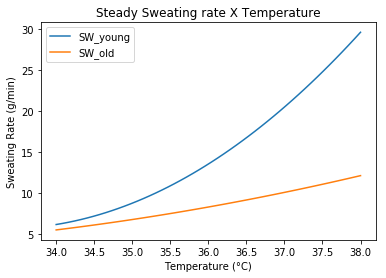

In [21]:
x = np.linspace(34,38)
SW_young = 1214.5-72.6* x + 1.09* x**2
SW_old = 117 - 7.7 * x + 0.13* x**2
plt.plot(x,SW_young)
plt.plot(x,SW_old)
plt.legend(['SW_young', 'SW_old'], loc='upper left')
plt.title('Steady Sweating rate X Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Sweating Rate (g/min)')
plt.show()

#### 2.4.2 Model of evaporative heat loss 

Then, the sweating rate relates to the evaporative heat loss as follows [[6]]

\begin{equation}
\tag{II}
EV = min \,(\frac {SW \times 40.6}{S} , EV_{max} )
\end{equation}

where the $40.6$ is a unit conversion coefficient , $EV_{max}$ $[W/cm^2]$ is the maximum evaporative heat loss - that here will be considered bigger than $SW \times 40.6/S$ because of the interval chosen for the temperature - and $S$ is the surface area of the human body, which we are going to set as $18000 \; cm^2$.

We are then going to calculate $S_{young}(\theta_{out})$ and $S_{old}(\theta_{out})$ and, with these values, calculate $EV_{young}$ and $EV_{old}$. It's important to remark that these values will be different each time, since $\theta_{out}$ is a random variable.Therefore, we can determine $EV_{young}$ and $EV_{old}$ in our Python script, since we have already computed. 



[6]: https://www.sciencedirect.com/science/article/pii/S1290072914003032 

In [22]:
S = 18000 #cm^2
#Calculating the sweating rates
SW_young = 1214.5 - 72.6 * u_amb + 1.09* (u_amb**2)
SW_old  = 117 - 7.7* u_amb + 0.13* (u_amb**2)
#Calculating the evaporative heat loss
EV_young = SW_young* 40.6 / 18000
EV_old = SW_old* 40.6 / 18000

### 2.5 Definition and parametrization of the domain

Since we are interested in computing the temperature distribution in human bodies, we are going to define $\Omega$ as a domain which approximates the shape of the human body. However, for simplicity's sake, we will define a two-dimensional body. For that, we will use as inspiration the human body curve from [wolframalpha][2], which is made with Fourier Series, and take out some small order terms, in order to decrease the computation time. Notice that we multiply it by $70$ in order to get to a similar order of magnitude to a human body

By doing this process, we obtain the following parametrization for the human body. 

[2]: https://www.wolframalpha.com/input/?i=2d+man+curve

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


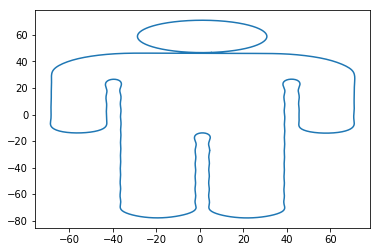

In [9]:
t = np.linspace(0, 25.13, 3000)

x = 1/350*((4618/31*np.sin(t+3) +49/9)*np.heaviside(7*np.pi - t,1)*np.heaviside(t-3*np.pi,1) + \
    (-1/56*np.sin(7/9 - 60*t)-3/8*np.sin(7/5 - 54*t)-4/13*np.sin(1/4-46*t)-6/11*np.sin(9/8-30*t)-16/5*np.sin(6/7-28*t)-11/4*np.sin(4/5-27*t) -35/11*np.sin(5/11 - 25*t)-861/43*np.sin(6/7-6*t)-1548/19*np.sin(4/7-4*t)-1372/13*np.sin(2/7-2*t)\
    +1783/7*np.sin(t+3)+229/3*np.sin(3*t +19/7)+25/2*np.sin(5*t +22/9)+26/3*np.sin(7*t +15/7) + 53/5*np.sin(8*t +73/37)+83/6*np.sin(9*t+11/6)+10/3*np.sin(10*t+11/7)+64/7*np.sin(11*t+8/5)+106/15*np.sin(12*t+23/5)+28/3*np.sin(13*t + 35/8)+52/17*np.sin(14*t+12/11)+100/11*np.sin(15*t+41/10)+23/6*np.sin(16*t+4/5)+58/9*np.sin(17*t+7/10)+25/11*np.sin(18*t+5/11)+21/5*np.sin(19*t+3/7)+5/3*np.sin(20*t+1/5)+32/11*np.sin(21*t+23/7)+8/17*np.sin(22*t+19/7)+24/7*np.sin(23*t+3)+6/7*np.sin(24*t+17/6)+9/14*np.sin(26*t+5/2)+27/14*np.sin(29*t +15/7)+1/9*np.sin(31*t+27/7)+12/7*np.sin(32*t+5/3)+10/19*np.sin(33*t+23/5)+7/15*np.sin(34*t+32/7)+5/8*np.sin(35*t+38/9)+8/7*np.sin(36*t+48/11)+1/6*np.sin(37*t+17/11)+7/10*np.sin(38*t+39/10)+3/5*np.sin(39*t+34/9)+7/6*np.sin(40*t+6/11)+23/24*np.sin(41*t+17/5)+4/9*np.sin(42*t +17/5)+5/8*np.sin(43*t+1/12)+3/5*np.sin(44*t+64/21)+1/2*np.sin(45*t+104/35)+1/4*np.sin(47*t +25/9)+4/9*np.sin(48*t+16/7)+3/7*np.sin(49*t+7/3)+1/7*np.sin(50*t+2)+2/11*np.sin(51*t+31/15)+8/17*np.sin(52*t+7/4)+1/5*np.sin(53*t+23/5)+3/7*np.sin(55*t+10/7)+1/6*np.sin(56*t+6/5)+1/23*np.sin(57*t+40/11)+4/7*np.sin(58*t+13/14)+4/7*np.sin(59*t+11/12)+32/5)*np.heaviside(3*np.pi - t,1)*np.heaviside(t+np.pi,1))*np.heaviside(np.sqrt(np.sign(np.sin(t/2))),1)
y = 1/850*((889/6*np.sin(t + 32/7)+3572/5)*np.heaviside(7*np.pi - t,1)*np.heaviside(t-3*np.pi,1)\
    +(-3/7*np.sin(3/4 -59*t)-1/7*np.sin(7/11 - 58*t)-2/9*np.sin(2/7-56*t)-9/17*np.sin(1/7-55*t)-1/19*np.sin(14/13-44*t)-1/15*np.sin(16/15 - 43*t)-1/7*np.sin(6/7-39*t)-3/2*np.sin(9/19 - 36*t)-5/4*np.sin(1/43 -33*t)-178/21*np.sin(19/13-21*t)-15/7*np.sin(4/3-20*t)-8/3*np.sin(21/20-18*t)-23/11*np.sin(9/10-17*t)-106/11*np.sin(5/8-15*t)-49/6*np.sin(7/15-14*t)-73/4*np.sin(4/13-13*t)-22/9*np.sin(1/5-12*t)-13/14*np.sin(1/14-11*t)\
    +1576/3*np.sin(t + 32/7)+221/9*np.sin(2*t + 14/11)+227/3*np.sin(3*t +9/8)+2713/9*np.sin(4*t+1)+56/9*np.sin(5*t +69/17)+159/7*np.sin(6*t+7/10)+480/7*np.sin(7*t+5/9)+255/7*np.sin(8*t+32/9)+129/7*np.sin(9*t+17/5)+159/10*np.sin(10*t+1/8)+119/24*np.sin(16*t+17/7)+85/13*np.sin(19*t+33/17)+10/9*np.sin(22*t+8/5)+70/23*np.sin(23*t+9/2)+47/9*np.sin(24*t+35/8)+7/6*np.sin(25*t+7/6)+3/5*np.sin(26*t+28/29)+2/7*np.sin(27*t+35/9)+4/7*np.sin(28*t+19/5)+7/11*np.sin(29*t+40/11)+1/7*np.sin(30*t+38/11)+19/7*np.sin(31*t+10/3)+27/13*np.sin(32*t+16/5)+11/7*np.sin(34*t+23/8)+13/12*np.sin(35*t+25/9)+5/9*np.sin(37*t+43/17)+13/9*np.sin(38*t+7/3)+4/7*np.sin(40*t+2)+7/8*np.sin(41*t+15/8)+7/10*np.sin(42*t+22/13)+7/8*np.sin(45*t+13/10)+1/7*np.sin(46*t+14/11)+2/5*np.sin(47*t+38/9)+36/37*np.sin(48*t+8/9)+4/9*np.sin(49*t+5/7)+2/5*np.sin(50*t+42/11)+6/11*np.sin(51*t+2/5)+4/7*np.sin(52*t+2/7)+1/9*np.sin(53*t+11/3)+1/7*np.sin(54*t+1/22)+1/9*np.sin(57*t+25/9)+1/9*np.sin(60*t+12/5)-307/2)*np.heaviside(3*np.pi - t,1)*np.heaviside(t+np.pi,1))*np.heaviside(np.sqrt(np.sign(np.sin(t/2))),1)   

x *= 70
y *= 70
plt.plot(x,y)
plt.show()

## 3. Solution of the problem

### 3.1 Meshing the domain

Now that we have defined the domain, we can start meshing it, which will be the first step of our solution. 

Our domain is quite complicated and we have some problems while trying to use the usual FeniCS mesher. Luckly, our domain can be easily separated in some simpler subdomains, such as the right and left arm (RA,LA), the head (HD), the chest (CH) and the left and right leg (LL, RL). With this separation, it becomes possible to use the *generate_mesh* function from the module *mshr* to mesh a combination of Polygonal domains. By doing this we get the following mesh. 

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in sqrt


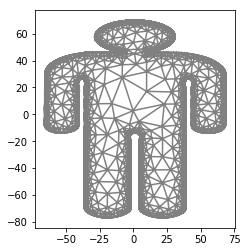

In [10]:
mesh = Mesh()
time = np.linspace(0, 25.13, 5000)
RA = [] #Right Arm
LA = [] #Left Arm
CH = [] #Chest
HD = [] #Head
LL = [] #Left Leg
RL = [] #Right Leg

# Here we will just determine some points of our domain, in order to generate the polygonal domains after. 
for t in time:
    x = 1/350*((4618/31*np.sin(t+3) +49/9)*np.heaviside(7*np.pi - t,1)*np.heaviside(t-3*np.pi,1) + \
        (-1/56*np.sin(7/9 - 60*t)-3/8*np.sin(7/5 - 54*t)-4/13*np.sin(1/4-46*t)-6/11*np.sin(9/8-30*t)-16/5*np.sin(6/7-28*t)-11/4*np.sin(4/5-27*t) -35/11*np.sin(5/11 - 25*t)-861/43*np.sin(6/7-6*t)-1548/19*np.sin(4/7-4*t)-1372/13*np.sin(2/7-2*t)\
        +1783/7*np.sin(t+3)+229/3*np.sin(3*t +19/7)+25/2*np.sin(5*t +22/9)+26/3*np.sin(7*t +15/7) + 53/5*np.sin(8*t +73/37)+83/6*np.sin(9*t+11/6)+10/3*np.sin(10*t+11/7)+64/7*np.sin(11*t+8/5)+106/15*np.sin(12*t+23/5)+28/3*np.sin(13*t + 35/8)+52/17*np.sin(14*t+12/11)+100/11*np.sin(15*t+41/10)+23/6*np.sin(16*t+4/5)+58/9*np.sin(17*t+7/10)+25/11*np.sin(18*t+5/11)+21/5*np.sin(19*t+3/7)+5/3*np.sin(20*t+1/5)+32/11*np.sin(21*t+23/7)+8/17*np.sin(22*t+19/7)+24/7*np.sin(23*t+3)+6/7*np.sin(24*t+17/6)+9/14*np.sin(26*t+5/2)+27/14*np.sin(29*t +15/7)+1/9*np.sin(31*t+27/7)+12/7*np.sin(32*t+5/3)+10/19*np.sin(33*t+23/5)+7/15*np.sin(34*t+32/7)+5/8*np.sin(35*t+38/9)+8/7*np.sin(36*t+48/11)+1/6*np.sin(37*t+17/11)+7/10*np.sin(38*t+39/10)+3/5*np.sin(39*t+34/9)+7/6*np.sin(40*t+6/11)+23/24*np.sin(41*t+17/5)+4/9*np.sin(42*t +17/5)+5/8*np.sin(43*t+1/12)+3/5*np.sin(44*t+64/21)+1/2*np.sin(45*t+104/35)+1/4*np.sin(47*t +25/9)+4/9*np.sin(48*t+16/7)+3/7*np.sin(49*t+7/3)+1/7*np.sin(50*t+2)+2/11*np.sin(51*t+31/15)+8/17*np.sin(52*t+7/4)+1/5*np.sin(53*t+23/5)+3/7*np.sin(55*t+10/7)+1/6*np.sin(56*t+6/5)+1/23*np.sin(57*t+40/11)+4/7*np.sin(58*t+13/14)+4/7*np.sin(59*t+11/12)+32/5)*np.heaviside(3*np.pi - t,1)*np.heaviside(t+np.pi,1))*np.heaviside(np.sqrt(np.sign(np.sin(t/2))),1)
    y = 1/850*((889/6*np.sin(t + 32/7)+3572/5)*np.heaviside(7*np.pi - t,1)*np.heaviside(t-3*np.pi,1)\
        +(-3/7*np.sin(3/4 -59*t)-1/7*np.sin(7/11 - 58*t)-2/9*np.sin(2/7-56*t)-9/17*np.sin(1/7-55*t)-1/19*np.sin(14/13-44*t)-1/15*np.sin(16/15 - 43*t)-1/7*np.sin(6/7-39*t)-3/2*np.sin(9/19 - 36*t)-5/4*np.sin(1/43 -33*t)-178/21*np.sin(19/13-21*t)-15/7*np.sin(4/3-20*t)-8/3*np.sin(21/20-18*t)-23/11*np.sin(9/10-17*t)-106/11*np.sin(5/8-15*t)-49/6*np.sin(7/15-14*t)-73/4*np.sin(4/13-13*t)-22/9*np.sin(1/5-12*t)-13/14*np.sin(1/14-11*t)\
        +1576/3*np.sin(t + 32/7)+221/9*np.sin(2*t + 14/11)+227/3*np.sin(3*t +9/8)+2713/9*np.sin(4*t+1)+56/9*np.sin(5*t +69/17)+159/7*np.sin(6*t+7/10)+480/7*np.sin(7*t+5/9)+255/7*np.sin(8*t+32/9)+129/7*np.sin(9*t+17/5)+159/10*np.sin(10*t+1/8)+119/24*np.sin(16*t+17/7)+85/13*np.sin(19*t+33/17)+10/9*np.sin(22*t+8/5)+70/23*np.sin(23*t+9/2)+47/9*np.sin(24*t+35/8)+7/6*np.sin(25*t+7/6)+3/5*np.sin(26*t+28/29)+2/7*np.sin(27*t+35/9)+4/7*np.sin(28*t+19/5)+7/11*np.sin(29*t+40/11)+1/7*np.sin(30*t+38/11)+19/7*np.sin(31*t+10/3)+27/13*np.sin(32*t+16/5)+11/7*np.sin(34*t+23/8)+13/12*np.sin(35*t+25/9)+5/9*np.sin(37*t+43/17)+13/9*np.sin(38*t+7/3)+4/7*np.sin(40*t+2)+7/8*np.sin(41*t+15/8)+7/10*np.sin(42*t+22/13)+7/8*np.sin(45*t+13/10)+1/7*np.sin(46*t+14/11)+2/5*np.sin(47*t+38/9)+36/37*np.sin(48*t+8/9)+4/9*np.sin(49*t+5/7)+2/5*np.sin(50*t+42/11)+6/11*np.sin(51*t+2/5)+4/7*np.sin(52*t+2/7)+1/9*np.sin(53*t+11/3)+1/7*np.sin(54*t+1/22)+1/9*np.sin(57*t+25/9)+1/9*np.sin(60*t+12/5)-307/2)*np.heaviside(3*np.pi - t,1)*np.heaviside(t+np.pi,1))*np.heaviside(np.sqrt(np.sign(np.sin(t/2))),1)   
    
    x *= 70
    y*=70
    
    #Then we can simply define each region by the position of each point of our domain.
    if x >= 0.56*70:
        RA.insert(0, Point(x - 0.035*70,y))
    if x <= -0.527*70:
        LA.insert(0, Point(x + 0.035*70,y))
    if y >= 0.666*70:
        HD.insert(0, Point(x,y-0.015*70))
    if y >= -0.22*70 and y <= 0.666*70 and x >= -0.527*70 and x <= 0.56*70:
        CH.insert(0, Point(x,y))
    if y <= -0.22*70 and x >= -0.53*70 and x <= 0:
        LL.insert(0, Point(x,y+ 70* 0.013))
    if y <= -0.22*70 and x >= 0 and x <= 0.56*70:
        RL.insert(0, Point(x,y+ 70* 0.013))
        
mesh = generate_mesh(Polygon(HD)+Polygon(CH)+Polygon(RA)+Polygon(LA)+Polygon(LL)+Polygon(RL), 1)
plot(mesh)

### 3.2 Defining the approximation Space


We need to define the space on which we will look for our approximate solution. Since it doesn't vanish on the boundary, we will choose $\mathcal{H}_h$ = {$v \in \mathcal{H}^1 : v_{|\partial\Omega} \in \mathcal{P}^1$}. 
Thus, we define $\mathcal{H}_h$ in our Python script. 

In [23]:
Hh = FunctionSpace(mesh, 'P', 1)

### 3.3 Variational Approximation

For the weak formulation (WF), let's consider a function $\phi$ $\in$ $\mathcal{D}(\overline{\Omega})$. Then, we write:

\begin{equation}
 \int_\Omega -\nabla(\kappa \nabla(u)) \phi - \rho_{b} c_{b} \omega_{b} (\theta_{art} - u) \phi = \int_\Omega f \phi. 
\end{equation}

Using Integration by Parts on the left hand side and applying the Robin's boundary condition, we get:


\begin{equation}
 \tag{WF}
  \int_\Omega \kappa \nabla(u) \nabla(\phi) + \int_{\partial\Omega}  (h (u - \theta_{out}) + E V) \phi - \int_\Omega \rho_{b} c_{b} \omega_{b} (\theta_{art} - u) \phi = \int_\Omega f \phi ,   \forall \phi \in \mathcal{D}(\overline{\Omega})
\end{equation}

For the Variational Formulation (VF), let's Consider a Space $\mathcal{H}$ = $\mathcal{H}^1(\Omega)$. Then, we can define the bilinear form $a(u,v)$ and the linear form $l(v)$.

$a: \mathcal{H} x \mathcal{H} \rightarrow \mathbb{R}$

$ \quad \; (u,v) \mapsto \int_\Omega \kappa \nabla(u) \nabla(\phi) + \int_{\partial\Omega}  h \,u\, v + \int_\Omega \rho_{b} c_{b} \omega_{b} \,u\, v$

$l: \mathcal{H} \rightarrow \mathbb{R}$

$ \quad \:  v \mapsto \int_\Omega f v + \int_\Omega \rho_{b} c_{b} \omega_{b} \theta_{art} v + \int_{\partial\Omega}  (h \theta_{out} - E V) v$


We now add the variational formulation as defined above to the Python script.

In [24]:
u = TrialFunction(Hh)
v = TestFunction(Hh)
a = k*dot(grad(u), grad(v))*dx +ro_b*c*w*u*v*dx + h*u*v*ds 
l_old = f*v*dx + (ro_b*c*w*u_ar)*v*dx + (h*u_amb - EV_old)*v*ds
l_young = f*v*dx + (ro_b*c*w*u_ar)*v*dx + (h*u_amb - EV_young)*v*ds

### 3.4 Solving and plotting the solution

#### 3.4.1 Plotting the eldery person solution

Then, we can just solve, for both the young and old cases the problem: Find $u_h \in \mathcal{H}_h$ s.t  $\, \forall v_h \in \mathcal{H}_h \: ,a(u_h,v_h) = l(v_h)$ and plot the obtained solutions.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5,1,'Temp.[°C] in eldery person')

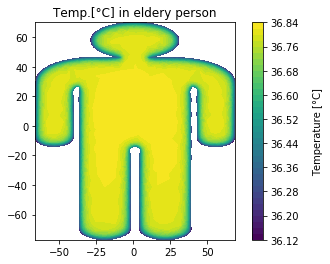

In [25]:
u_old = Function(Hh)
solve(a == l_old, u_old)
u_young = Function(Hh)
solve(a == l_young, u_young)

a = plot(u_old)
cb_a = plt.colorbar(a)
cb_a.set_label("Temperature [°C]", labelpad= 15)
plt.title('Temp.[°C] in eldery person')


We can see that the temperature is quite constant in the middle, but it decreases continuosly when getting near the boundary. If we then *zoom* it in a region near the boundary, to see how it is actually behaving we get:

[30, 40, 15, 20]

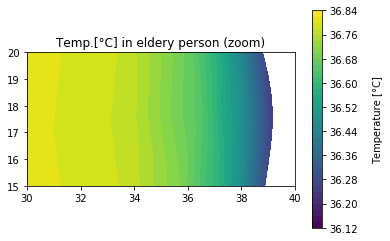

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
a = plot(u_old)
cb_a = plt.colorbar(a)
cb_a.set_label("Temperature [°C]", labelpad= 15)
plt.title('Temp.[°C] in eldery person (zoom)')
ax.axis([30,40,15,20])

We can see that it behaves almost continously, but yet, the color bands are discrete, which are a result of the discretize solution. 
#### 3.4.2 Plotting the difference between old and young person

If we then make the difference between $u_{old}$ and $u_{young}$, we get:

Text(0.5,1,'Diff. between eldery and young person')

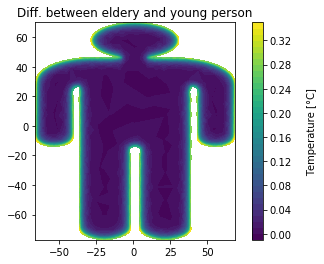

In [27]:
b = plot(u_old - u_young)
cb_b = plt.colorbar(b)
cb_b.set_label("Temperature [°C]", labelpad= 15)
plt.title('Diff. between eldery and young person')

We can see that the main difference happens near the boundary, which is a natural result considering our model and the fact that the differences between the two cases are basically in the Robin's boundary condition. 
If we then *zoom* it in a region near the boundary, to see how it is actually behaving we get:

[30, 40, 15, 20]

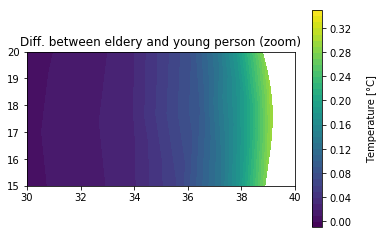

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
b = plot(u_old - u_young)
cb_b = plt.colorbar(b)
cb_b.set_label("Temperature [°C]", labelpad= 15)
plt.title('Diff. between eldery and young person (zoom)')
ax.axis([30,40,15,20])

We get a similar behaviour to the other *zoom* we did before. 

## 4. Analysis of the solution and conclusions

### 4.1 Temperature distribution on eldery person

Even if we used a really simple model, if compared to the complexity of the human body, we were able to get some great and insightful results regarding the temperature distribution in the human body. If we compare the first plot we got with a result from [[7]], that is represented in this [image][1] , we can notice that the temperature profile we got is actually quite accurate for the case of high weather temperature, which is the case of our study. Both are pretty constant inside the body, in a higher temperature, and gets colder when one gets closer to the boundary. However, we can notice that, for some values of the random variables, the temperature we get is a little bit colder than the results from [[7]], probably because of the simplifications we did while developing the model, for example to the $\kappa$, to the $f$ or to the fact that the we used a 2-dimensional model.

### 4.2 Difference between an eldery and a young person

If we analyse the plot of the difference between the temperatures of an eldery person and a young person we can see that, indeed, we got that the older person gets hotter when exposed to higher temperatures, since it has a smaller sweating rate, which is related to the high deaths of eldery people during the *canicules*. However, it is important to make a remark: actually, eldery people have a lower temperature, because of several biological factors, such as the blood circulation. Anyway, when we set $\kappa$ , $f$ and all other parameters equal between both, we have disregarded this initial change in temperatures, since we only wanted to see how much it would change when exposed to high temperatures because of the effect of the sweating mechanisms.  
An other important remark is that the difference of temperature is concentrated near to  the skin. This is a result of the simplified model used and the changes in the Robin's boundary condition. However, usually, we would get also some changes inside the domain.

### 4.3 Effect of randomness on the model

We developed our model using random variables to describe the outside temperature ($\theta_{out}$), the arterial temperature ($\theta_{art}$) and the initial conductivity ($\kappa_{0}$). If we simulate multiple times we can see that indeed, both results change, mainly in relation to the range of the temperatures.This is obviously expected, since we are changing some characteristics of the body and the environment. However, we can notice that the patterns are maintained, i.e. we always get results such as described in the items above. That happens because we selectioned random values from intervals which are in accordance with the model's assumptions. 

### 4.4 Final thoughts

In general, the model described really well the expected result and indicated that, indeed, the low sweating rates might be a critical factor for eldery people during the *canicules*. However, it is important to remark that a lot of assumptions and simplifications were made. Thus, the model could, of course, be improved, in order to represent even better the reality. Some ideas for future projects would be to divide the parameters in each layer of the body, do the model in 3-dimensions and take into account more metabolic differences between the eldery and younger people. However, overall, the project provided some useful insights and allowed the group to develop some key modeling skills. 

[1]: https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=3401950_nihms391790f1.jpg
[7]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3401950/

## 5. References:

[1]: *Bilan de la canicule 2019*, avaiable at: https://www.vie-publique.fr/en-bref/270623-bilan-de-la-canicule-2019-1-500-deces-enregistres-cet-ete

[2]: *Heat Transfer and Fluid Flow in Biological Processes*, available at: https://www.sciencedirect.com/book/9780124080775/heat-transfer-and-fluid-flow-in-biological-processes

[3]: *WolframAlpha*, available at: https://www.wolframalpha.com/input/?i=2d+man+curve

[4]: *Mathematical Study of Temperature Distribution in Human Dermal Part during Physical Exercises*, available at:  https://www.researchgate.net/publication/313958781

[5]: *Simulation and Calculation of Magnetic and Thermal Fields of Human using Numerical Method and Robust Softwares*, available at: http://www.diva-portal.org/smash/get/diva2:37698/FULLTEXT01.pdf

[6]: *Computational estimation of body temperature and sweating in the aged during passive heat exposure*, avaiable at: https://www.sciencedirect.com/science/article/pii/S1290072914003032

[7]: * Human body temperature and new approaches to constructing temperature-sensitive bacterial vaccines*, avaiable at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3401950/

[8]: *Relationship between skin blood flow and sweating rate, and age related regional differences*, avaible at: https://www.ncbi.nlm.nih.gov/pubmed/10052655

[9]: *Lecture notes on Polynomial Interpolation by UNICAMP*, avaiable at: https://www.ime.unicamp.br/~valle/Teaching/2015/MS211/Aula19.pdf














